# Imports

In [1]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
import autograd.numpy.random as npr
from autograd.misc.optimizers import adam
import os

# Function Definitions

In [2]:
# Weight initialisation
def init_random_params(scale, layer_sizes, rs=npr.RandomState(42)):
    return [(rs.randn(insize, outsize) * scale,   # weight matrix
             rs.randn(outsize) * scale)           # bias vector
            for insize, outsize in zip(layer_sizes[:-1], layer_sizes[1:])]

# Activation function
def tanh(x):
    return (2 / (1.0 + np.exp(-2*x))) - 1
    #return np.log(1+np.exp(x))
    #return np.exp(x)

# Returns the NN output AFTER enforcing the boundary condition. This is the wavefunction (wf).
def psi(nnparams, inputs):
    origInput = inputs
    xTilde = (origInput - x0) / (x1 - x0)
    
    for W, b in nnparams:
        outputs = np.dot(inputs, W) + b
        inputs = tanh(outputs)    
        
    # Enforcing the boundary conditions
    return (1-xTilde)*psi0 + xTilde*psi1 + (1-np.exp(xTilde * (1 - xTilde))) * outputs


dpsi = elementwise_grad(psi, 1) # Function for returning first derivative of wf (not used explicitly)
ddpsi = elementwise_grad(dpsi, 1) # Second derivative of wf. 

In [3]:
def energyStr (paramsE) :
    Efloat = float(paramsE)
    Eint = int(np.floor(Efloat))

    if Efloat - Eint == 0 :
        return "E" + str(int(np.floor(Efloat)))
    else :
        Estr = str(Efloat)
        return "E" + str(int(np.floor(Efloat))) + "p" + Estr[Estr.find('.')+1:]

# Objective function
def objective(params, step):
    nnparams = params['nn']
    E = params['E']        
    
    wf = psi(nnparams,x)    # Wavefunction
    diffeq = -0.5 * ddpsi(nnparams, x)  - E*wf  # Schrodinger equation in functional form
    y2 = wf**2   # Probability density function
    
    # This is a numerical trapezoid integration
    prob = np.sum((y2[1:] + y2[0:-1]) / 2 * (x[1:] - x[0:-1]))
    
    # First term is the MSE, second term is used to constrain the probability to 1.
    #return np.mean(diffeq**2) + (1 - prob)**2 + 4/prob + (prob**4)
    return 20*np.mean(diffeq**2) + 100*(1 - prob)**2 + 200/prob + (200/4)*(prob**4)


iterList = []
diffeqList = []
probList = []
lossList = []
EList = []
# Helper function for callback. Prints the following -
# 1. Iteration no.
# 2. MSE term
# 3. Probability integral
# 4. Loss
# 5. Eigen-energy 
def objectiveDebug (params, step) :
    nnparams = params['nn']
    E = params['E']   
    
    wf = psi(nnparams,x)    # Wavefunction
    diffeq = -0.5 * ddpsi(nnparams, x)  - E*wf  # Schrodinger equation in functional form
    y2 = wf**2   # Probability density function
    mean = np.mean(diffeq**2)  # MSE

    # This is a numerical trapezoid integration
    prob = np.sum((y2[1:] + y2[0:-1]) / 2 * (x[1:] - x[0:-1]))
    
    loss = 20*mean + 100*(1 - prob)**2 + 200/prob + (200/4)*(prob**4)
    
    iterList.append (step)
    diffeqList.append (mean)
    probList.append (prob)
    lossList.append (loss)
    EList.append (float(params['E']))
    
    print ("Iteration " + str(step) + " diffeq = " + str(mean) + " prob = " + str(prob))
    print ("loss = " + str(loss) + " E = " + str(params['E']))
    print ("---------------------------------")
    

# Callback function.
def callback(params, step, g):
    if step % 100 == 0:
        objectiveDebug (params, step)

# Initialisation

In [4]:
psi0 = 0 # Value of first boundary
psi1 = 0 # Value of second boundary
L = 1 # Length of the well
n = 1 # Energy level to be found
scale = 2 # Scale for initialisation
divs = 200 # divisions of the input space

x0 = 0  # Position of first boundary
x1 = L  # Position of second boundary

In [5]:
# Initialising the weights. They usually fall between 0 and 1 which causes the initial wavefunction
# to have a small probability integral over the range. Hence, I've put a scale factor of 2 that changes gives it
# a random (but sizeable) shape so that over the epochs, the probability integral converges to 1.
nnparams = init_random_params(scale/(x1-x0), layer_sizes=[1, 32, 32, 32, 1])

# The ground state energy of the particle in a box is (pi^2)/2 = 4.9348. I've initialised E to 4.0
# so that it converges to the eigenenergy quickly.
params = {'nn': nnparams, 'E': 4.0}

# Input space
x = np.linspace(x0, x1, divs)[:, None]

# Setting up the name for saving files
name = "n" + str(n)+ "L" + str(L) + energyStr(params['E'])

# Optimization

In [6]:
params = adam(grad(objective), params,
              step_size=0.001, num_iters=10001, callback=callback) 

Iteration 0 diffeq = 1254433.5880188523 prob = 5.018478203279003
loss = 25122040.95202979 E = 4.0
---------------------------------
Iteration 100 diffeq = 21667.528684288733 prob = 4.412671522258521
loss = 453517.8269529481 E = 4.084353869033777
---------------------------------
Iteration 200 diffeq = 4440.323247185329 prob = 2.5427326387986793
loss = 91213.25045631874 E = 4.121930881460713
---------------------------------
Iteration 300 diffeq = 2696.9349320103497 prob = 2.2046480247913594
loss = 55355.74360227699 E = 4.146355546440131
---------------------------------
Iteration 400 diffeq = 1886.7541976853242 prob = 2.1551081961807346
loss = 39039.879202523654 E = 4.169957517312397
---------------------------------
Iteration 500 diffeq = 1450.6531831568636 prob = 2.105388774479061
loss = 30212.671001609095 E = 4.1946199336557415
---------------------------------
Iteration 600 diffeq = 1227.6654609169477 prob = 2.050361037025385
loss = 25644.85139844825 E = 4.220804867983317
---------

Iteration 5500 diffeq = 1.698029842762511 prob = 1.0010910950392005
loss = 283.961311148635 E = 4.945607754589474
---------------------------------
Iteration 5600 diffeq = 1.5563131126017102 prob = 1.0010355391534431
loss = 281.12690565712444 E = 4.9454928713937605
---------------------------------
Iteration 5700 diffeq = 2.0606061017573305 prob = 1.0039159261740198
loss = 291.22132278042994 E = 4.945365479672252
---------------------------------
Iteration 5800 diffeq = 1.2821116007484639 prob = 1.00181569068795
loss = 275.644210057287 E = 4.945228413308837
---------------------------------
Iteration 5900 diffeq = 1.1845426075121073 prob = 1.0015960619155537
loss = 273.6923806000454 E = 4.945082665527057
---------------------------------
Iteration 6000 diffeq = 1.199003579502984 prob = 1.0011846748123232
loss = 273.9809136631982 E = 4.944929503267908
---------------------------------
Iteration 6100 diffeq = 1.7516573831864557 prob = 1.0023476465294872
loss = 285.0364545378453 E = 4.944

# Plots

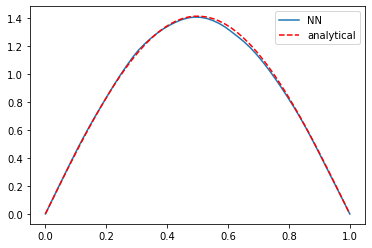

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
x = np.linspace(x0, x1)[:, None]
y = psi(params['nn'], x)

plt.plot(x, y, label='NN')  # Plotting the NN output
plt.plot(x, np.sqrt(2/L) * np.sin(n*np.pi * (x-x0)/L), 'r--', label='analytical')  # Plotting the actual wavefuncion
plt.legend()
plt.savefig (name + "_plot.png")

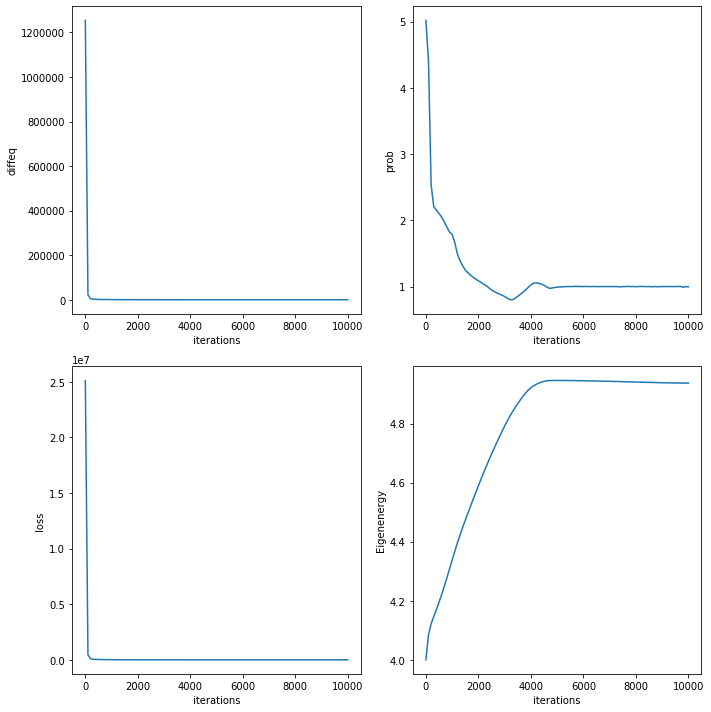

In [8]:
fig = plt.figure (figsize=(10,10))
plt.clf ()

plt.subplot (2 , 2 , 1)
plt.plot (iterList, diffeqList)
plt.xlabel ('iterations')
plt.ylabel ('diffeq')

plt.subplot (2, 2, 2)
plt.plot (iterList, probList)
plt.xlabel ('iterations')
plt.ylabel ('prob')

plt.subplot (2, 2, 3)
plt.plot (iterList, lossList)
plt.xlabel ('iterations')
plt.ylabel ('loss')

plt.subplot (2, 2, 4)
plt.plot (iterList, EList)
plt.ylabel ('Eigenenergy')
plt.xlabel ('iterations')
plt.tight_layout()

plt.savefig (name + "_diagAll.png")

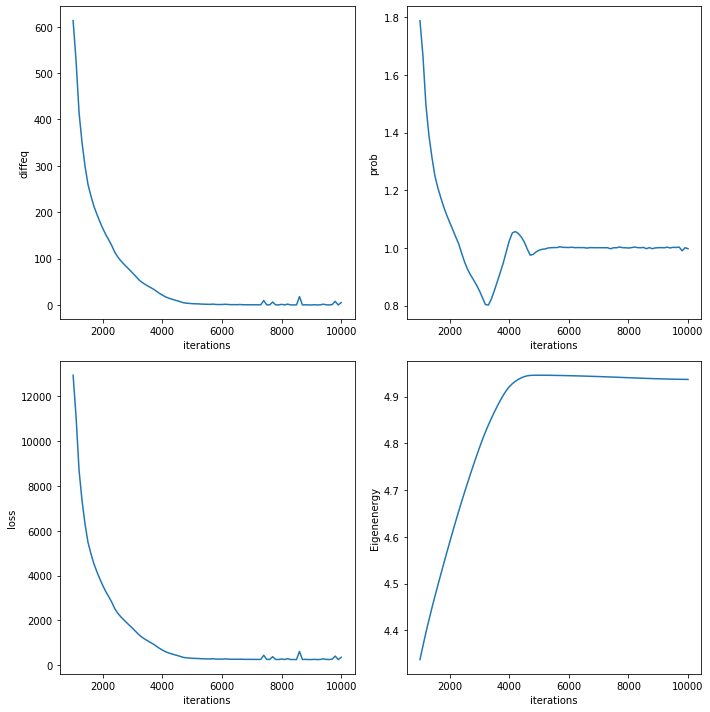

In [9]:
fig = plt.figure (figsize=(10,10))
trunc = 10

plt.subplot (2 , 2 , 1)
plt.plot (iterList[trunc:], diffeqList[trunc:])
plt.xlabel ('iterations')
plt.ylabel ('diffeq')

plt.subplot (2, 2, 2)
plt.plot (iterList[trunc:], probList[trunc:])
plt.xlabel ('iterations')
plt.ylabel ('prob')

plt.subplot (2, 2, 3)
plt.plot (iterList[trunc:], lossList[trunc:])
plt.xlabel ('iterations')
plt.ylabel ('loss')

plt.subplot (2, 2, 4)
plt.plot (iterList[trunc:], EList[trunc:])
plt.ylabel ('Eigenenergy')
plt.xlabel ('iterations')
plt.tight_layout()

plt.savefig (name + "_diagTrunc" + str(trunc) + ".png")

# Write to file

In [10]:
outfile = open(name + "_info.txt" , "w")

fstr = "diffeq = " + str(round(diffeqList[-1],8)) + "\nprob = " + str(round(probList[-1],8)) + "\nloss = " + str(round(lossList[-1],8)) + "\neigE = " + str(round(EList[-1],8))
    
outfile.write (fstr)
outfile.close ()

In [ ]:
print ("\diffeq = " + str(round(diffeqList[-1],8)) + ", \prob = " + str(round(probList[-1],8)) + 
       ", \loss = " + str(round(lossList[-1],8)) + ", \eigE = " + str(round(EList[-1],8)))